In [20]:
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [2]:
#! code $(jupyter --data-dir)/nbextensions/snippets/snippets.json

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking


Plan:

1) load 1 image in 
2) look at it
3) resize it 

4) create uber basic CNN that is happy to take it as input

5) point it at more images

6) get it on google colab

Questions


In [38]:
path_to_dataset = os.path.join("..", "data", "raw_data","kaggle_ingredients")

test_folder = "apple"

batch_size = 32
img_height = 180
img_width = 180

train_ds = image_dataset_from_directory(
  path_to_dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = image_dataset_from_directory(
  path_to_dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#images = image_dataset_from_directory(path_to_dataset, )

Found 119387 files belonging to 53 classes.
Using 95510 files for training.
Found 119387 files belonging to 53 classes.
Using 23877 files for validation.


In [16]:
train_ds.class_names
type(train_ds)#.__dict__

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [32]:
count = 0
test_image, test_label = None, None

for image, label in train_ds.take(1):
    if count == 0 :
        test_image = image
        test_label = label
    count+=1
    if count > 0: break
print("test label shape: ", test_label.shape)
print(test_label)
print("image shape:" ,test_image.shape)

test label shape:  (32,)
tf.Tensor(
[21 34 51 44 14 28 37 27 43 10 50 15  3  0 37 26 12 38 28 22 18 25 32 51
 23 43 43 10 41  3  3 12], shape=(32,), dtype=int32)
image shape: (32, 180, 180, 3)


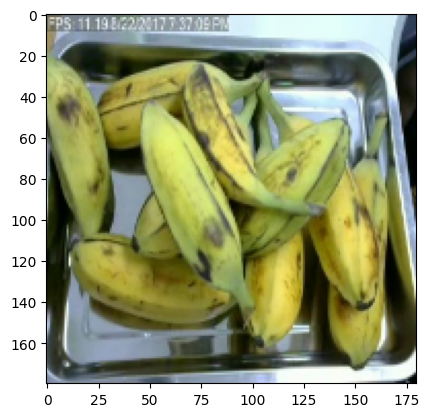

In [39]:
plt.imshow(test_image[12]/255)

## CNN